# Bitcoin price forecast


In [106]:
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [107]:
# dataset @ https://finance.yahoo.com/quote/BTC-USD/history/
df = pd.read_csv('BTC-USD.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-24,3584.500244,3616.087402,3569.092773,3600.865479,3600.865479,5.262869e+09
1,2019-01-25,3607.390381,3612.927734,3575.597412,3599.765869,3599.765869,5.265848e+09
2,2019-01-26,3599.715332,3654.933105,3593.345947,3602.460449,3602.460449,5.098183e+09
3,2019-01-27,3604.687256,3612.671387,3567.245850,3583.965820,3583.965820,5.570753e+09
4,2019-01-28,3584.283203,3586.750977,3439.232910,3470.450439,3470.450439,6.908930e+09


In [108]:
df = df[['Date', 'Volume', 'Close']]
df.head()

,Date,Volume,Close
0,2019-01-24,5.262869e+09,3600.865479
1,2019-01-25,5.265848e+09,3599.765869
2,2019-01-26,5.098183e+09,3602.460449
3,2019-01-27,5.570753e+09,3583.965820
4,2019-01-28,6.908930e+09,3470.450439


In [109]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [110]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date'].head()

0   2019-01-24
1   2019-01-25
2   2019-01-26
3   2019-01-27
4   2019-01-28
Name: Date, dtype: datetime64[ns]

In [111]:
df.index = df.pop('Date')
df.head()

,Volume,Close
Date,,
2019-01-24,5.262869e+09,3600.865479
2019-01-25,5.265848e+09,3599.765869
2019-01-26,5.098183e+09,3602.460449
2019-01-27,5.570753e+09,3583.965820
2019-01-28,6.908930e+09,3470.450439


In [112]:
df['Change'] = df['Close'].pct_change(periods=2)
df.drop(df.index[:2], inplace=True)
df.head()

,Volume,Close,Change
Date,,,
2019-01-26,5.098183e+09,3602.460449,0.000443
2019-01-27,5.570753e+09,3583.965820,-0.004389
2019-01-28,6.908930e+09,3470.450439,-0.036644
2019-01-29,5.897159e+09,3448.116943,-0.037905
2019-01-30,5.955113e+09,3486.181641,0.004533


In [113]:
df['Change_bin'] = (df['Change'] >= 0.005).astype(int)
df.head()

,Volume,Close,Change,Change_bin
Date,,,,
2019-01-26,5.098183e+09,3602.460449,0.000443,0
2019-01-27,5.570753e+09,3583.965820,-0.004389,0
2019-01-28,6.908930e+09,3470.450439,-0.036644,0
2019-01-29,5.897159e+09,3448.116943,-0.037905,0
2019-01-30,5.955113e+09,3486.181641,0.004533,0


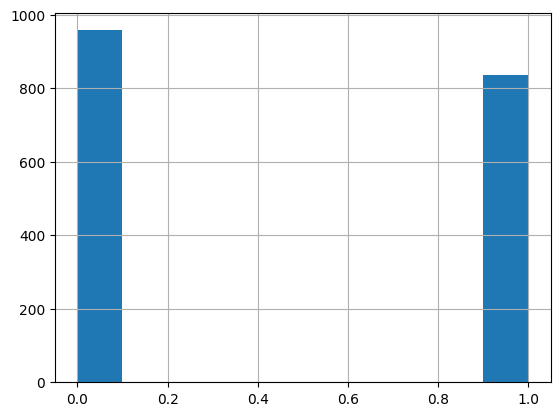

In [114]:
df['Change_bin'].hist()
plt.show()

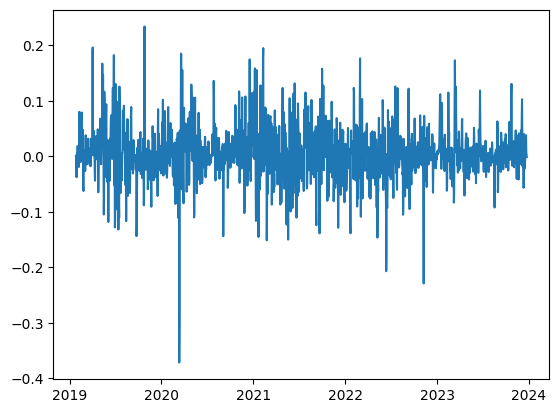

In [115]:
plt.plot(df.index, df['Change'])

In [116]:
scaler = MinMaxScaler(feature_range=(0, 1))
change_scaled = scaler.fit_transform(df['Change'].values.reshape(-1,1))
close_scaled = scaler.fit_transform(df['Close'].values.reshape(-1,1))
df['Change'] = change_scaled
df['Close'] = close_scaled
df.head()

,Volume,Close,Change,Change_bin
Date,,,,
2019-01-26,5.098183e+09,0.003163,0.614582,0
2019-01-27,5.570753e+09,0.002875,0.606599,0
2019-01-28,6.908930e+09,0.001106,0.553311,0
2019-01-29,5.897159e+09,0.000758,0.551229,0
2019-01-30,5.955113e+09,0.001351,0.621339,0


In [117]:
import numpy as np

def df_to_windowed_df(dataframe, n=3):
  target = dataframe.loc[:,df.columns[-1]].to_numpy()
  dates = dataframe.index[n:].to_numpy()
  Y = target[n:]
  feat_amount = len(df.columns) - 1
  input_columns = []
  for i in range(1, feat_amount + 1):
    input_columns.append(dataframe.loc[:,dataframe.columns[-1 * i - 1]].to_numpy())

  X = []
  for i in range(feat_amount):
    X.append([])
  for i in range(1, n + 1):
    for j in range(feat_amount):
      X[j].append(input_columns[j][n-i:-i])

  for i in range(feat_amount):
    X[i].reverse()

  ret_df = pd.DataFrame()
  ret_df['Date'] = dates

  for i in range(0, n):
    for j in range(feat_amount):
      ret_df[f'Target-{j}-{n-i}'] = X[j][i]

  ret_df['Target'] = Y

  return ret_df

windowed_df = df_to_windowed_df(df, n=10)
windowed_df.head()

,Date,Target-0-10,Target-1-10,Target-2-10,Target-0-9,Target-1-9,Target-2-9,Target-0-8,Target-1-8,Target-2-8,...,Target-0-3,Target-1-3,Target-2-3,Target-0-2,Target-1-2,Target-2-2,Target-0-1,Target-1-1,Target-2-1,Target
0,2019-02-05,0.614582,0.003163,5.098183e+09,0.606599,0.002875,5.570753e+09,0.553311,0.001106,6.908930e+09,...,0.644079,0.001895,5.071624e+09,0.602515,0.001006,5.043938e+09,0.584804,0.000930,5.332719e+09,0
1,2019-02-06,0.606599,0.002875,5.570753e+09,0.553311,0.001106,6.908930e+09,0.551229,0.000758,5.897159e+09,...,0.602515,0.001006,5.043938e+09,0.584804,0.000930,5.332719e+09,0.614968,0.001042,5.227550e+09,0
2,2019-02-07,0.553311,0.001106,6.908930e+09,0.551229,0.000758,5.897159e+09,0.621339,0.001351,5.955113e+09,...,0.584804,0.000930,5.332719e+09,0.614968,0.001042,5.227550e+09,0.592174,0.000223,5.482196e+09,0
3,2019-02-08,0.551229,0.000758,5.897159e+09,0.621339,0.001351,5.955113e+09,0.618486,0.000909,5.831198e+09,...,0.614968,0.001042,5.227550e+09,0.592174,0.000223,5.482196e+09,0.581972,0.000000,5.004963e+09,1
4,2019-02-09,0.621339,0.001351,5.955113e+09,0.618486,0.000909,5.831198e+09,0.614686,0.001379,5.422927e+09,...,0.592174,0.000223,5.482196e+09,0.581972,0.000000,5.004963e+09,0.736296,0.004166,7.735623e+09,1


In [118]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)
dates.shape, X.shape, y.shape

((1784,), (1784, 30, 1), (1784,))

In [119]:
train_percentage = 0.7
val_percentage = 0.1
test_percentage = 0.2

assert train_percentage + val_percentage + test_percentage == 1

lim_train = int(len(dates) * train_percentage)
lim_val = int(len(dates) * val_percentage)

dates_train, X_train, y_train = dates[:lim_train], X[:lim_train], y[:lim_train]
dates_val, X_val, y_val = dates[lim_train: lim_train + lim_val], X[lim_train: lim_train + lim_val], y[lim_train: lim_train + lim_val]
dates_test, X_test, y_test = dates[ lim_train + lim_val:], X[ lim_train + lim_val:], y[ lim_train + lim_val:]

In [120]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import InverseTimeDecay
from tensorflow.keras import layers, regularizers
from sklearn.utils.class_weight import compute_class_weight

# Suponiendo que y_train es tu conjunto de etiquetas de entrenamiento
# Calcula los pesos de las clases
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.flatten())
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(class_weight_dict)

# Modificaciones en la arquitectura del modelo
model = Sequential()
model.add(layers.LSTM(64, input_shape=(30, 1), activation='tanh'))  # Uso de tanh y sigmoid
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Ajustes en la tasa de aprendizaje y el decaimiento
lr_schedule = InverseTimeDecay(0.01,
                               decay_steps=10000,
                               decay_rate=0.95,
                               staircase=True)

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule),
              metrics=['accuracy'])

# Entrenamiento del modelo
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, class_weight=class_weight_dict)

{0: 0.9719626168224299, 1: 1.0297029702970297}
Epoch 1/20
39/39 [==============================] - 3s 30ms/step - loss: 0.7979 - accuracy: 0.4968 - val_loss: 0.6888 - val_accuracy: 0.6461
Epoch 2/20
39/39 [==============================] - 1s 15ms/step - loss: 0.7018 - accuracy: 0.4936 - val_loss: 0.6980 - val_accuracy: 0.3539
Epoch 3/20
39/39 [==============================] - 1s 14ms/step - loss: 0.6955 - accuracy: 0.4848 - val_loss: 0.6928 - val_accuracy: 0.6461
Epoch 4/20
39/39 [==============================] - 1s 14ms/step - loss: 0.6942 - accuracy: 0.4679 - val_loss: 0.6923 - val_accuracy: 0.6461
Epoch 5/20
39/39 [==============================] - 1s 15ms/step - loss: 0.6934 - accuracy: 0.5144 - val_loss: 0.6881 - val_accuracy: 0.6461
Epoch 6/20
39/39 [==============================] - 1s 14ms/step - loss: 0.6934 - accuracy: 0.5144 - val_loss: 0.6925 - val_accuracy: 0.6461
Epoch 7/20
39/39 [==============================] - 1s 19ms/step - loss: 0.6933 - accuracy: 0.4663 - val_lo

39/39 [==============================] - 1s 6ms/step
[[642   0]
 [606   0]]


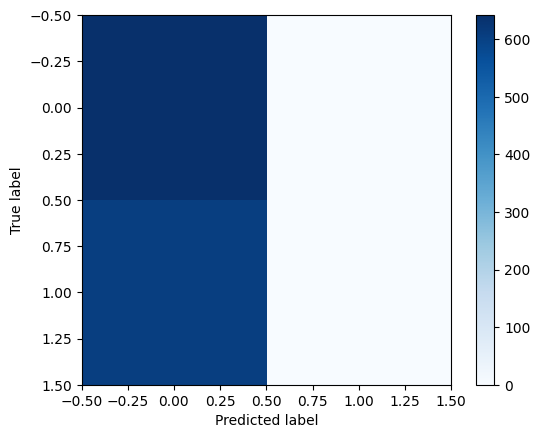

In [121]:
# prompt: plot confusion matrix

from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_train)

# Threshold para convertir la salida del modelo en una predicción binaria
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Calcular la matriz de confusión
cm = confusion_matrix(y_train, y_pred_binary)

# Imprimir la matriz de confusión
print(cm)

# Graficar la matriz de confusión
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [122]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_train)
y_pred = np.round(y_pred)

# confusion matrix
import sklearn.metrics as skm

cm = confusion_matrix(y_train, y_pred)
cr = classification_report(y_train, y_pred)

print("Matriz de Confusión:")
print(cm)
print("\nClassification Report:")
print(cr)

39/39 [==============================] - 0s 6ms/step
Matriz de Confusión:
[[642   0]
 [606   0]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.51      1.00      0.68       642
         1.0       0.00      0.00      0.00       606

    accuracy                           0.51      1248
   macro avg       0.26      0.50      0.34      1248
weighted avg       0.26      0.51      0.35      1248



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


39/39 [==============================] - 0s 6ms/step


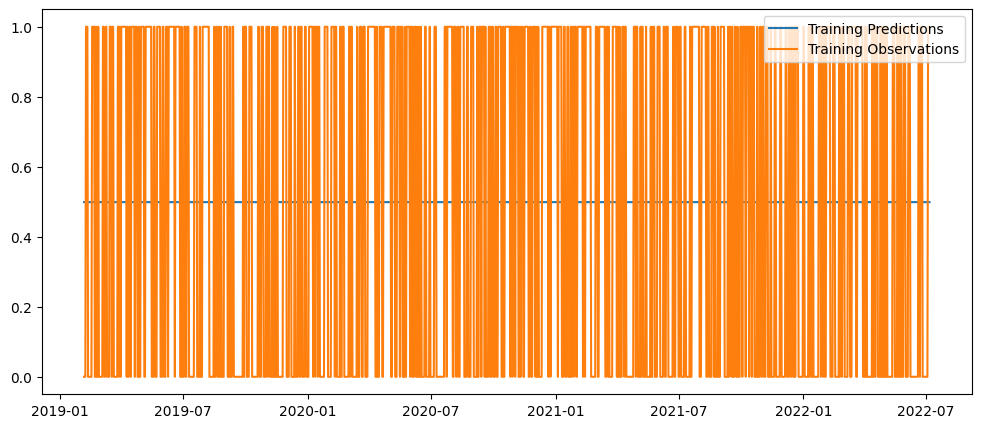

In [123]:
train_predictions = model.predict(X_train).flatten()

plt.figure(figsize=(12, 5))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

6/6 [==============================] - 0s 7ms/step


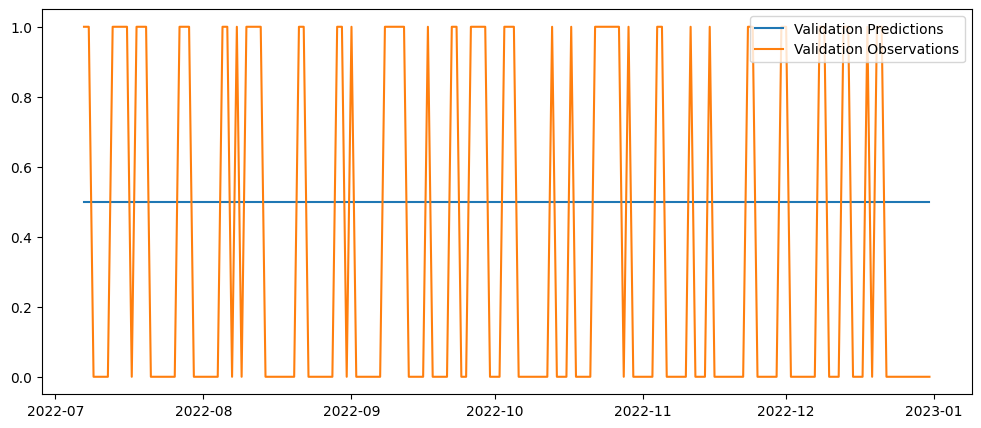

In [124]:
val_predictions = model.predict(X_val).flatten()

plt.figure(figsize=(12, 5))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

12/12 [==============================] - 0s 6ms/step


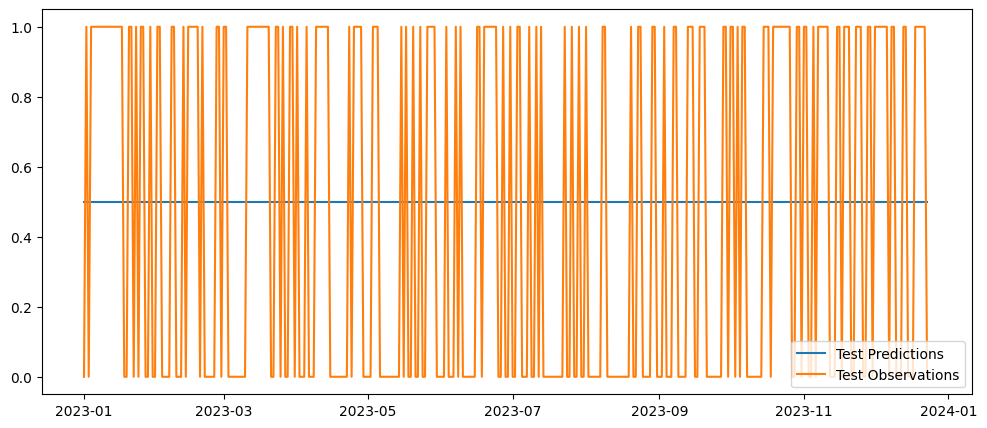

In [125]:
test_predictions = model.predict(X_test).flatten()

plt.figure(figsize=(12, 5))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Test Predictions', 'Test Observations'])